In [38]:
import numpy as np
import xarray as xr
import pandas as pd

# Load SST and grid data (assume same for both JRA and CORE2)
npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sst = npz["sstc"]
coast = npz["coast"]
lono = npz["lonc"]
lato = npz["latc"]
time = npz["time"]
lat = np.mean(lato, axis=1)  

# Prepare heat budget list: [JRA, CORE2]
fname = 'heat_budget_mld1_fjra_1993_2022.npz'
npz = np.load(fname, allow_pickle=True)
budget = {
    'tdc': npz['tdc_c'],
    'advx': npz['advx_c'],
    'advy': npz['advy_c'],
    'advz': npz['advz_c'],
    'sbc': npz['sbc_c'],
    'diffv': npz['diffv_c'],
}
budget_errors = {
    'tdc': npz['tdc_c_std'],
    'advx': npz['advx_c_std'],
    'advy': npz['advy_c_std'],
    'advz': npz['advz_c_std'],
    'sbc': npz['sbc_c_std'],
    'diffv': npz['diffv_c_std'],
}

# Now heat_budgets[0] is JRA, heat_budgets[1] is CORE2, each a dict with all terms and a label


Keys in the npz file: KeysView(NpzFile 'sstu_1993_2022.npz' with keys: lon, lat, sstu, sstc, coast...)


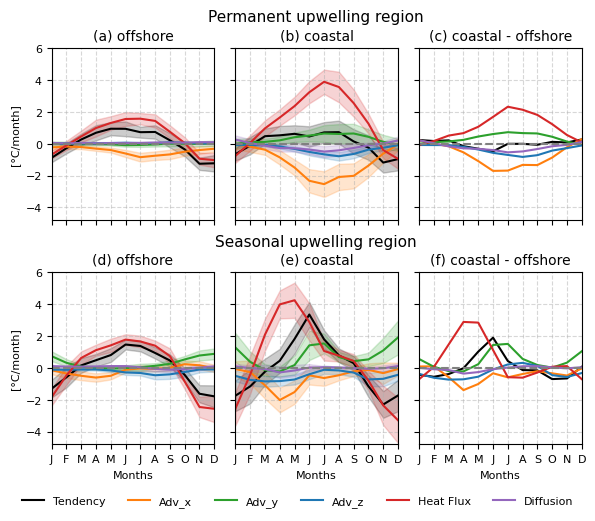

In [39]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
panel_labels = list("abcdefghijklmnopqrstuvwxyz")

def plot_budget_results(lat, budget_terms, budget_errors, latitude_bands):
    """Plot the mean evolution of budget terms for specified latitude bands with shaded error regions."""
    
    labels = ["Tendency", "Adv_x", "Adv_y", "Adv_z", "Heat Flux", "Diffusion"]
    colors = {
        "Tendency": "k", 
        "Adv_x": "tab:orange",
        "Adv_y": "tab:green", 
        "Adv_z": "tab:blue",
        "Heat Flux": "tab:red", 
        "Diffusion": "tab:purple",
    }
    row_titles = ["Permanent upwelling region", "Seasonal upwelling region"]

    dt = 86400 * 30  # seconds in 1 month
    fig, axes = plt.subplots(len(latitude_bands), 3, figsize=(6, 5), sharex=True, sharey=True)

    for row, (lat_min, lat_max) in enumerate(latitude_bands):
        mask = (lat >= lat_min) & (lat <= lat_max)
        for col in range(3):  # 0: offshore, 1: coastal, 2: diff
            ax = axes[row, col]

            terms = [budget['tdc'], budget['advx'], budget['advy'], budget['advz'], budget['sbc'], budget['diffv']]
            errors = [budget_errors['tdc'], budget_errors['advx'], budget_errors['advy'], budget_errors['advz'], budget_errors['sbc'], budget_errors['diffv']]
            for term, error, label in zip(terms, errors, labels):

                color = colors.get(label, None)
                linestyle = "--" if label == "Sum" else "-"  

                if col == 0:  # offshore
                    mean_evolution = np.nanmean(term[:, mask, :8], axis=(1, 2)) * dt
                    std_error = np.nanmean(error[:, mask, :8], axis=(1, 2)) * dt if error is not None else None
                elif col == 1:  # coastal
                    mean_evolution = np.nanmean(term[:, mask, 8:], axis=(1, 2)) * dt
                    std_error = np.nanmean(error[:, mask, 8:], axis=(1, 2)) * dt if error is not None else None
                else:  # diff (coastal - offshore)
                    mean_coastal = np.nanmean(term[:, mask, 8:], axis=(1, 2))
                    mean_offshore = np.nanmean(term[:, mask, :8], axis=(1, 2))
                    mean_evolution = (mean_coastal - mean_offshore) * dt
                    std_error = None  

                ax.plot(range(term.shape[0]), mean_evolution, 
                        label=label if row == 0 and col == 0 else "_nolegend_", 
                        color=color, linestyle=linestyle)
                
                if std_error is not None and col < 2:
                    ax.fill_between(range(term.shape[0]), mean_evolution - std_error, mean_evolution + std_error, color=color, alpha=0.2, label="_nolegend_")


            ax.axhline(0, linestyle='dashed', color='gray')
            ax.grid(True, linestyle='--', alpha=0.5)

            ax.set_ylim(-4.8, 6)
            ax.set_xlim(0, term.shape[0] - 1)
            panel_idx = row * 3 + col
            prefix = f"({panel_labels[panel_idx]}) "
            title = ["offshore", "coastal", "coastal - offshore"][col]
            ax.set_title(f"{prefix}{title}", fontsize=10)
            if col == 0:
                ax.set_ylabel("[°C/month]")

    for ax in axes[-1, :]:  
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Months")

    fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留顶部空间
    fig.subplots_adjust(hspace=0.3)   # ← 加大两行子图之间的竖向间距


    row_titles = [
        "Permanent upwelling region",
        "Seasonal upwelling region"
    ]

    for i, title in enumerate(row_titles):
        y = 1.0 - (i + 0.5) * .45 + 0.16

        fig.text(
            0.53, y, title,
            ha='center', va='bottom',
            fontsize=11
        )

    

# Latitude bands
latitude_bands = [(21, 30), (12, 19)]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plot_budget_results(lat, 
                    budget,  
                    budget_errors,  
                    latitude_bands)
plt.savefig("fig8.png", dpi=300, bbox_inches='tight')                    
plt.show()

In [5]:
budget

{'advx': array([[[ 7.43224943e-08,  6.56210735e-08,  6.56210735e-08, ...,
           6.82887634e-08, -3.84524275e-08, -3.22921541e-08],
         [ 7.43224943e-08,  7.43224943e-08,  1.12004221e-07, ...,
           6.82887634e-08,  6.82887634e-08,  6.82887634e-08],
         [ 7.43224943e-08,  1.12004221e-07,  1.12004221e-07, ...,
           1.55491618e-07,  6.82887634e-08,  1.37632399e-08],
         ...,
         [ 1.77102574e-08,  1.47467578e-08,  1.47467578e-08, ...,
           7.70215622e-10,  7.70215622e-10, -6.99241338e-08],
         [ 1.77102574e-08,  1.73867088e-08,  1.73867088e-08, ...,
           7.70215622e-10, -2.73526822e-08, -6.99241338e-08],
         [ 1.73867088e-08,  1.73867088e-08,  1.68149296e-08, ...,
          -2.73526822e-08, -1.92709599e-08, -1.92709599e-08]],
 
        [[ 8.46286730e-09,  1.07806436e-08,  1.07806436e-08, ...,
           5.36864658e-08, -5.49115618e-08,  9.87839447e-09],
         [ 8.46286730e-09,  8.46286730e-09, -7.45644976e-09, ...,
           5.

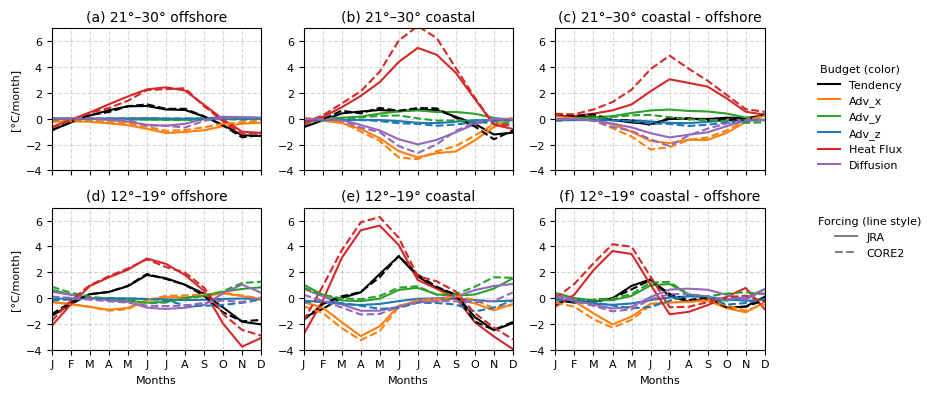

In [14]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
panel_labels = list("abcdefghijklmnopqrstuvwxyz")

def plot_budget_results_compare(lat, heat_budgets, latitude_bands):
    """
    Plot the mean evolution of budget terms for specified latitude bands (no error bars),
    comparing JRA (solid) and CORE2 (dashed).
    """
    labels = ["Tendency", "Adv_x", "Adv_y", "Adv_z", "Heat Flux", "Diffusion"]
    colors = {
        "Tendency": "k", 
        "Adv_x": "tab:orange",
        "Adv_y": "tab:green", 
        "Adv_z": "tab:blue",
        "Heat Flux": "tab:red", 
        "Diffusion": "tab:purple",
    }
    linestyles = {
        "JRA": "solid",
        "CORE2": "dashed"
    }
    fig, axes = plt.subplots(len(latitude_bands), 3, figsize=(9, 4), sharex=True)

    for row, (lat_min, lat_max) in enumerate(latitude_bands):
        mask = (lat >= lat_min) & (lat <= lat_max)
        for col in range(3):  # 0: offshore, 1: coastal, 2: diff
            ax = axes[row, col]
            for budget in heat_budgets:
                label_prefix = budget['label']
                linestyle = linestyles.get(label_prefix, "solid")
                # Get the terms in the correct order
                terms = [budget['tdc'], budget['advx'], budget['advy'], budget['advz'], budget['sbc'], budget['diffv']]
                for term, label in zip(terms, labels):
                    color = colors.get(label, None)
                    if col == 0:  # offshore
                        mean_evolution = np.nanmean(term[:, mask, :8], axis=(1, 2)) * dt
                    elif col == 1:  # coastal
                        mean_evolution = np.nanmean(term[:, mask, 8:], axis=(1, 2)) * dt
                    else:  # diff (coastal - offshore)
                        mean_coastal = np.nanmean(term[:, mask, 8:], axis=(1, 2))
                        mean_offshore = np.nanmean(term[:, mask, :8], axis=(1, 2))
                        mean_evolution = (mean_coastal - mean_offshore) * dt

                    # Only show legend for first row, last col, and only for term (color)
                    show_legend = (row == 0 and col == 2 and label_prefix == "JRA")
                    legend_label = label if show_legend else "_nolegend_"
                    ax.plot(
                        range(term.shape[0]), mean_evolution,
                        label=legend_label,
                        color=color,
                        linestyle=linestyle,
                    )
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.set_ylim(-4, 7)
            ax.set_xlim(0, term.shape[0] - 1)
            panel_idx = row * 3 + col
            prefix = f"({panel_labels[panel_idx]}) "
            title = ["offshore", "coastal", "coastal - offshore"][col]
            ax.set_title(f"{prefix}{lat_min}°–{lat_max}° {title}", fontsize=10)
            if col == 0:
                ax.set_ylabel("[°C/month]")

    for ax in axes[-1, :]:  
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Months")

    # Build legend: only show one entry per term (color), and a separate legend for line style (experiment)
    # 1. Term legend (color)
    term_lines = []
    term_labels = []
    for label in labels:
        color = colors.get(label, None)
        line, = plt.plot([], [], color=color, linestyle='solid')
        term_lines.append(line)
        term_labels.append(label)
    # 2. Experiment legend (line style)
    exp_lines = []
    exp_labels = []
    for label_prefix, linestyle in linestyles.items():
        line, = plt.plot([], [], color='gray', linestyle=linestyle)
        exp_lines.append(line)
        exp_labels.append(label_prefix)
    # Place legends at the right
    # Place term legend (color) at upper right outside the axes
    fig.legend(term_lines, term_labels, loc='center left', bbox_to_anchor=(0.9, 0.7), ncol=1, frameon=False, title="Budget (color)")
    # Place experiment legend (line style) below term legend
    fig.legend(exp_lines, exp_labels, loc='center left', bbox_to_anchor=(0.9, 0.4), ncol=1, frameon=False, title="Forcing (line style)")
    plt.tight_layout(rect=[0, 0, 0.87, 1])  # leave space at right for legend

# Latitude bands
dt = 86400 * 30  # seconds in 1 month
latitude_bands = [(21, 30), (12, 19)]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

plot_budget_results_compare(
    lat,
    heat_budgets,
    latitude_bands
)
plt.savefig("fig7.png", dpi=300, bbox_inches='tight')                    
plt.show()

Keys in the npz file: KeysView(NpzFile 'sstu_1993_2022.npz' with keys: lon, lat, sstu, sstc, coast...)
Keys in the npz file (PERU): KeysView(NpzFile 'heat_budget_peru_fjra_1993_2022.npz' with keys: advx_c, advy_c, advz_c, diffv_c, sbc_c...)


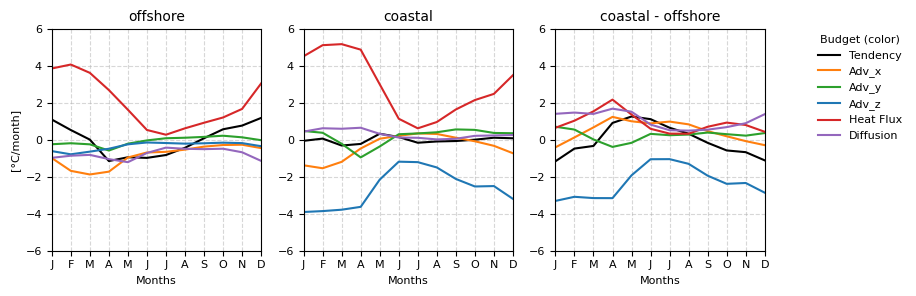

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load SST and grid data (assume same for both JRA and CORE2)
npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sst = npz["sstc"]
coast = npz["coast"]
lono = npz["lonc"]
lato = npz["latc"]
time = npz["time"]
lat = np.mean(lato, axis=1)  

# Only load one experiment (PERU)
fname = 'heat_budget_peru_fjra_1993_2022.npz'
label = 'PERU'
npz = np.load(fname, allow_pickle=True)
print(f"Keys in the npz file ({label}):", npz.keys())
budget = {
    'advx': npz['advx_c'],
    'advy': npz['advy_c'],
    'advz': npz['advz_c'],
    'diffv': npz['diffv_c'],
    'sbc': npz['sbc_c'],
    'tdc': npz['tdc_c'],
    'label': label
}

plt.rcParams.update({'font.size': 8})

def plot_budget_peru(lat, budget):
    """
    Plot the mean evolution of budget terms for the full latitude range (no error bars),
    for the PERU experiment only.
    """
    labels = ["Tendency", "Adv_x", "Adv_y", "Adv_z", "Heat Flux", "Diffusion"]
    colors = {
        "Tendency": "k", 
        "Adv_x": "tab:orange",
        "Adv_y": "tab:green", 
        "Adv_z": "tab:blue",
        "Heat Flux": "tab:red", 
        "Diffusion": "tab:purple",
    }
    dt = 86400 * 30  # seconds in 1 month
    month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
    for col in range(3):  # 0: offshore, 1: coastal, 2: diff
        ax = axes[col]
        terms = [budget['tdc'], budget['advx'], budget['advy'], budget['advz'], budget['sbc'], budget['diffv']]
        for term, label in zip(terms, labels):
            color = colors.get(label, None)
            if col == 0:  # offshore
                mean_evolution = np.nanmean(term[:, :, :4], axis=(1, 2)) * dt
            elif col == 1:  # coastal
                mean_evolution = np.nanmean(term[:, :, 20:], axis=(1, 2)) * dt
            else:  # diff (coastal - offshore)
                mean_coastal = np.nanmean(term[:, :, 20:], axis=(1, 2))
                mean_offshore = np.nanmean(term[:, :, :4], axis=(1, 2))
                mean_evolution = (mean_coastal - mean_offshore) * dt

            ax.plot(
                range(term.shape[0]), mean_evolution,
                label=label,
                color=color,
                linestyle='solid',
            )
        ax.grid(True, linestyle='--', alpha=0.5)
        if col == 2:
            ax.set_ylim(-6, 6)
        else:
            ax.set_ylim(-6, 6)
        ax.set_xlim(0, term.shape[0] - 1)
        title = ["offshore", "coastal", "coastal - offshore"][col]
        ax.set_title(f"{title}", fontsize=10)
        if col == 0:
            ax.set_ylabel("[°C/month]")

    for ax in axes:
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Months")

    # Build legend: only show one entry per term (color)
    term_lines = []
    term_labels = []
    for label in labels:
        color = colors.get(label, None)
        line, = plt.plot([], [], color=color, linestyle='solid')
        term_lines.append(line)
        term_labels.append(label)
    fig.legend(term_lines, term_labels, loc='center left', bbox_to_anchor=(0.9, 0.7), ncol=1, frameon=False, title="Budget (color)")
    plt.tight_layout(rect=[0, 0, 0.87, 1])  # leave space at right for legend

plot_budget_peru(lat, budget)
plt.savefig("fig7.png", dpi=300, bbox_inches='tight')                    
plt.show()